In [42]:
import json

import pandas as pd
import seaborn as sns
import wandb
import os

# Results
Get results from Weights and Biases and produce plots for paper

In [43]:
def get_data_from_wandb():

    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs("messer/JavaDoc-Relevance-Binary-Classifier")

    summary_list, config_list, name_list, group_list = [], [], [], []
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
             if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)
        group_list.append(run.group)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "group": group_list
    })

    runs_df.to_csv("data/training_results.csv")
    return runs_df

if not os.path.isfile("data/training_results.csv"):
    runs_df = get_data_from_wandb()

### Process WandB API call results

In [44]:
runs_df = pd.read_csv('data/training_results.csv')
runs_df['summary'] = runs_df['summary'].apply(lambda s: eval(s))
runs_df['config'] = runs_df['config'].apply(lambda s: eval(s))
runs_df.head()

,Unnamed: 0,summary,config,name,group
0,0,"{'eval/accuracy': 0.7441860465116279, 'eval/f1...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",bumbling-sun-1367,LORA:microsoft/codebert-base
1,1,"{'train/epoch': 39, 'eval/recall_macro': 0.927...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",worldly-resonance-1366,Fine-Tuned LLM:microsoft/codebert-base
2,2,{'_wandb': {'runtime': 1}},{},comfy-eon-1365,LORA:microsoft/codebert-base
3,3,"{'train/global_step': 312, 'eval/precision_wei...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",grateful-gorge-1364,LORA:microsoft/codebert-base
4,4,"{'train/train_samples_per_second': 55.641, '_s...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",fancy-river-1361,LORA:microsoft/codebert-base


In [45]:
df = pd.concat([runs_df[['name', 'group', 'config']], pd.json_normalize(runs_df['summary'])], axis=1)
df = df[~df['group'].str.contains('LORA')]

df.head()

,name,group,config,eval/accuracy,eval/f1_micro,eval/f1_weighted,eval/precision_weighted,_step,eval/recall_weighted,eval/samples_per_second,...,test/precision_weighted,test/runtime,test/accuracy,test/f1_macro,test/loss,test/f1_micro,test/steps_per_second,test/latency_in_seconds,test/total_time_in_seconds,split
1,worldly-resonance-1366,Fine-Tuned LLM:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",0.930233,0.930233,0.929913,0.931525,145.0,0.930233,114.200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,golden-terrain-1356,Fine-Tuned LLM:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",1.000000,1.000000,1.000000,1.000000,530.0,1.000000,117.912,...,0.896011,0.8195,0.88785,0.890343,1.846318,0.88785,8.542,NaN,NaN,NaN
6,laced-paper-1355,Fine-Tuned LLM:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",1.000000,1.000000,1.000000,1.000000,1030.0,1.000000,123.996,...,0.896011,0.8206,0.88785,0.890343,1.826392,0.88785,4.874,NaN,NaN,NaN
7,fresh-violet-1354,Fine-Tuned LLM:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",1.000000,1.000000,1.000000,1.000000,110.0,1.000000,116.073,...,0.896011,0.8137,0.88785,0.890343,1.825528,0.88785,8.603,NaN,NaN,NaN
8,earnest-sun-1353,Fine-Tuned LLM:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",1.000000,1.000000,1.000000,1.000000,520.0,1.000000,123.478,...,0.896011,0.8341,0.88785,0.890343,1.823859,0.88785,4.796,NaN,NaN,NaN


### Group and produce plots

In [46]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

In [47]:
grouped_df = df[['group', 'test/accuracy', 'test/precision_weighted', 'test/recall_weighted', 'test/f1_weighted']].groupby('group').max().reset_index()
grouped_df.columns = ['group', 'accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

grouped_df

,group,accuracy,precision_weighted,recall_weighted,f1_weighted
0,Bernolli,0.682243,0.692127,0.682243,0.680198
1,DecisionTree,0.616822,0.617826,0.616822,0.604051
2,Fine-Tuned LLM:bert-base-uncased,0.831776,0.834950,0.831776,0.829608
3,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536
4,KNeighbours,0.785047,0.796421,0.785047,0.783630
5,LogisticRegression,0.785047,0.791682,0.785047,0.775506
6,RandomForest,0.850467,0.865247,0.850467,0.833577


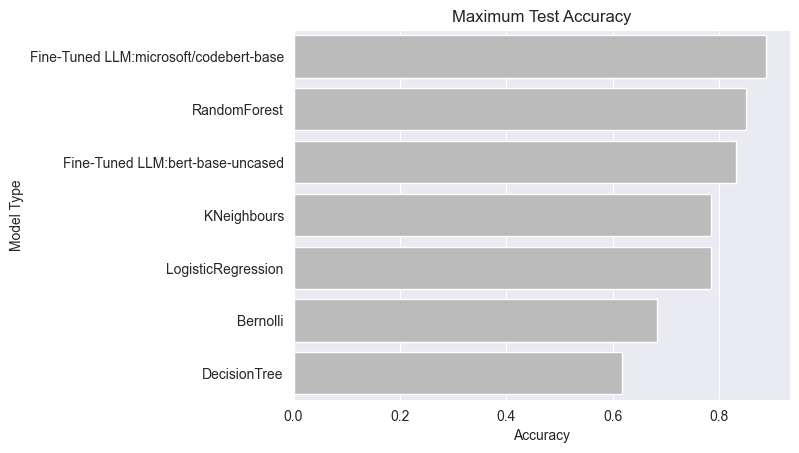

In [48]:
acc = sns.barplot(grouped_df[['group', 'accuracy']].sort_values('accuracy', ascending=False), y='group', x='accuracy', color=grey)
acc.set(title='Maximum Test Accuracy', xlabel='Accuracy', ylabel='Model Type')
acc.get_figure().savefig('plots/accuracy.pdf', bbox_inches='tight')

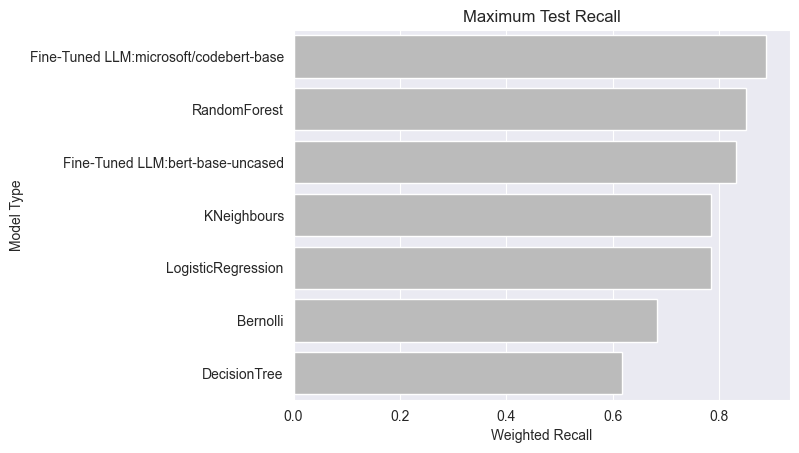

In [49]:
recall = sns.barplot(grouped_df[['group', 'recall_weighted']].sort_values('recall_weighted', ascending=False), y='group', x='recall_weighted', color=grey)
recall.set(title='Maximum Test Recall', xlabel='Weighted Recall', ylabel='Model Type')
recall.get_figure().savefig('plots/recall.pdf', bbox_inches='tight')

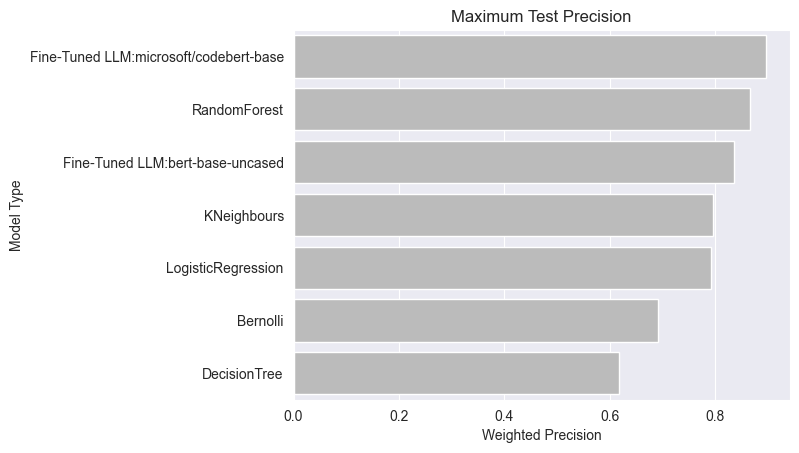

In [50]:
precision = sns.barplot(grouped_df[['group', 'precision_weighted']].sort_values('precision_weighted', ascending=False), y='group', x='precision_weighted', color=grey)
precision.set(title='Maximum Test Precision', xlabel='Weighted Precision', ylabel='Model Type')
precision.get_figure().savefig('plots/precision.pdf', bbox_inches='tight')

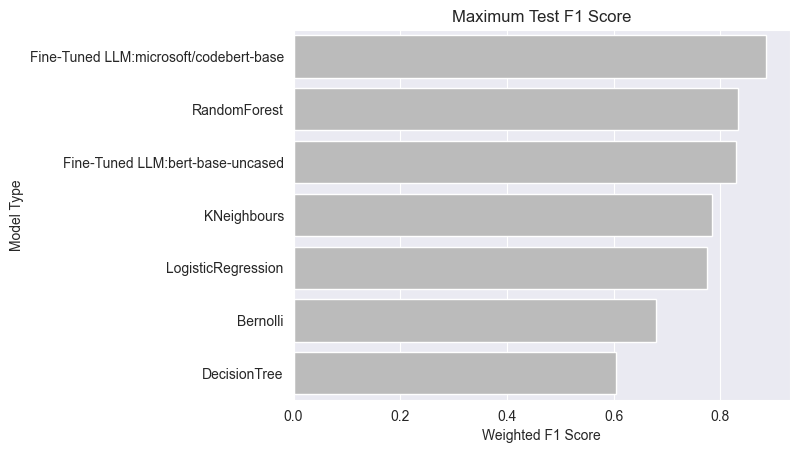

In [51]:
f1 = sns.barplot(grouped_df[['group', 'f1_weighted']].sort_values('f1_weighted', ascending=False), y='group', x='f1_weighted', color=grey)
f1.set(title='Maximum Test F1 Score', xlabel='Weighted F1 Score', ylabel='Model Type')
f1.get_figure().savefig('plots/f1.pdf', bbox_inches='tight')

In [52]:
grouped_df_melted = grouped_df.melt(id_vars=['group'])
grouped_df_melted['variable'] = grouped_df_melted['variable'].map(lambda metric_name: metric_name.title().replace('_Weighted', ''))
grouped_df_melted

,group,variable,value
0,Bernolli,Accuracy,0.682243
1,DecisionTree,Accuracy,0.616822
2,Fine-Tuned LLM:bert-base-uncased,Accuracy,0.831776
3,Fine-Tuned LLM:microsoft/codebert-base,Accuracy,0.887850
4,KNeighbours,Accuracy,0.785047
5,LogisticRegression,Accuracy,0.785047
6,RandomForest,Accuracy,0.850467
7,Bernolli,Precision,0.692127
8,DecisionTree,Precision,0.617826
9,Fine-Tuned LLM:bert-base-uncased,Precision,0.834950


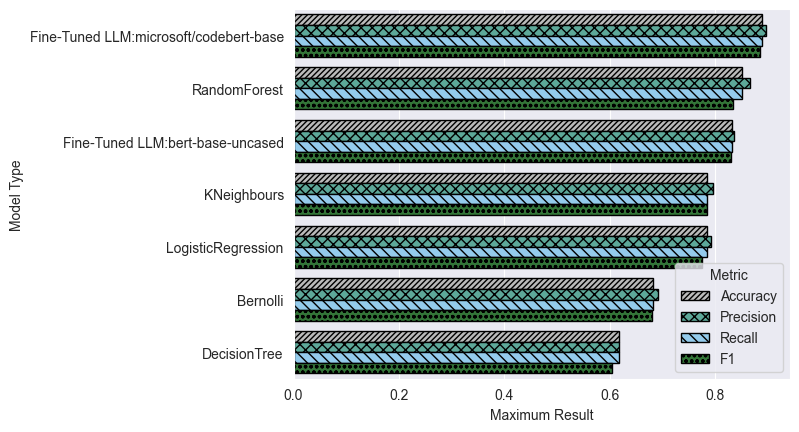

In [53]:
metrics = sns.barplot(grouped_df_melted.sort_values(['value'], ascending=False), y='group', x='value', hue='variable', hue_order=['Accuracy', 'Precision', 'Recall', 'F1'])


hatches = ['//', 'x', '\\', 'o']
colors = [grey, teal, blue, darkgreen]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, metrics.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

metrics.set(xlabel='Maximum Result', ylabel='Model Type')
metrics.legend(title='Metric')

metrics.get_figure().savefig('plots/metric_results.pdf', bbox_inches='tight')